In [1]:
import logging


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

In [ ]:
from src.datasets.dataset import CnnDataset
from src.datasets.mnist_dataset import MiniMNISTDataset
from src.models.cnn import CNNParams, ConvLayerParams, ConvParams
from src.models.compression.enums import Activation, NNParamsCompMode, QMode
from src.models.eval import KFoldNNArchitectureEvaluator
from src.models.mlp import FCLayerParams, FCParams
from src.models.nn import ActivationParams, NNTrainParams


def get_LeNet5_params(
    DatasetClass: type[CnnDataset],
    conv_weight_qmode: NNParamsCompMode = NNParamsCompMode.NONE,
    conv_activation: ActivationParams = ActivationParams(Activation.NONE),
    fc_weight_qmode: NNParamsCompMode = NNParamsCompMode.NONE,
    fc_activation: ActivationParams = ActivationParams(Activation.NONE),
    epochs: int = 1,
    early_stop_patience: int = 10,
) -> CNNParams:
    cnn_train_loader, cnn_test_loader = DatasetClass.get_dataloaders(50)

    conv_params = ConvParams(
        in_channels=DatasetClass.input_channels,
        in_dimensions=DatasetClass.input_dimensions,
        in_bitwidth=8,
        out_height=DatasetClass.output_size,
        layers=[
            ConvLayerParams(
                channels=32, kernel_size=5, stride=1, pooling_kernel_size=2
            ),
            ConvLayerParams(
                channels=64, kernel_size=5, stride=1, pooling_kernel_size=2
            ),
        ],
        compression=conv_weight_qmode,
        reste_threshold=1.5,
        reste_o=3,
        activation=conv_activation,
        dropout_rate=0.1,
    )
    cnn_fc_params = FCParams(
        layers=[
            FCLayerParams(512, fc_weight_qmode),
            FCLayerParams(DatasetClass.output_size, fc_weight_qmode),
        ],
        activation=fc_activation,
        qmode=QMode.DET,
        dropout_rate=0.0,
    )
    cnn_train_params = NNTrainParams(
        DatasetClass,
        cnn_train_loader,
        cnn_test_loader,
        epochs=epochs,
        learning_rate=0.001,
        weight_decay=0.00001,
        early_stop_patience=early_stop_patience,
    )
    cnn_params = CNNParams(
        in_bitwidth=8,
        conv=conv_params,
        fc=cnn_fc_params,
        train=cnn_train_params,
    )
    return cnn_params

In [3]:

datapoints = []

for compression in NNParamsCompMode:
    for activation in Activation:
        print(f"Evaluating LeNet5 with {compression} and {activation}...")

        model_params = get_LeNet5_params(
            DatasetClass=MiniMNISTDataset,
            conv_weight_qmode=compression,
            conv_activation=ActivationParams(activation),
            fc_weight_qmode=compression,
            fc_activation=ActivationParams(activation),
        )
        evaluator = KFoldNNArchitectureEvaluator(model_params)

        try:
            stats = evaluator.evaluate_accuracy(1)
        except Exception as e:
            logging.error(f"Error evaluating {compression} with {activation}: {e}")
            continue

        datapoints.append(
            {
                "architecture": "LeNet5",
                "dataset": MiniMNISTDataset.__name__,
                "compression": compression,
                "activation": activation,
                "top-1": stats["max"],
                "mean": stats["mean"],
                "accuracies": stats["accuracies"],
            }
        )

Evaluating LeNet5 with NNParamsCompMode.NONE and Activation.NONE...
Evaluating LeNet5 with NNParamsCompMode.NONE and Activation.RELU...
Evaluating LeNet5 with NNParamsCompMode.NONE and Activation.BINARIZE...
Evaluating LeNet5 with NNParamsCompMode.NONE and Activation.BINARIZE_RESTE...
Evaluating LeNet5 with NNParamsCompMode.NONE and Activation.TERNARIZE...
Evaluating LeNet5 with NNParamsCompMode.NBITS and Activation.NONE...


ERROR: Error evaluating NNParamsCompMode.NBITS with Activation.NONE: NBITS compression mode is not implemented for convolutional layers


Evaluating LeNet5 with NNParamsCompMode.NBITS and Activation.RELU...


ERROR: Error evaluating NNParamsCompMode.NBITS with Activation.RELU: NBITS compression mode is not implemented for convolutional layers


Evaluating LeNet5 with NNParamsCompMode.NBITS and Activation.BINARIZE...


ERROR: Error evaluating NNParamsCompMode.NBITS with Activation.BINARIZE: NBITS compression mode is not implemented for convolutional layers


Evaluating LeNet5 with NNParamsCompMode.NBITS and Activation.BINARIZE_RESTE...


ERROR: Error evaluating NNParamsCompMode.NBITS with Activation.BINARIZE_RESTE: NBITS compression mode is not implemented for convolutional layers


Evaluating LeNet5 with NNParamsCompMode.NBITS and Activation.TERNARIZE...


ERROR: Error evaluating NNParamsCompMode.NBITS with Activation.TERNARIZE: NBITS compression mode is not implemented for convolutional layers


Evaluating LeNet5 with NNParamsCompMode.BINARY and Activation.NONE...
Evaluating LeNet5 with NNParamsCompMode.BINARY and Activation.RELU...
Evaluating LeNet5 with NNParamsCompMode.BINARY and Activation.BINARIZE...
Evaluating LeNet5 with NNParamsCompMode.BINARY and Activation.BINARIZE_RESTE...
Evaluating LeNet5 with NNParamsCompMode.BINARY and Activation.TERNARIZE...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.NONE...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.RELU...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.BINARIZE...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.BINARIZE_RESTE...
Evaluating LeNet5 with NNParamsCompMode.TERNARY and Activation.TERNARIZE...


In [4]:
datapoints

[{'architecture': 'LeNet5',
  'dataset': 'MiniMNISTDataset',
  'compression': <NNParamsCompMode.NONE: 'none'>,
  'activation': <Activation.NONE: 'none'>,
  'top-1': 95.375,
  'mean': np.float64(94.0),
  'accuracies': [95.375, 93.875, 93.375, 93.375, 94.0]},
 {'architecture': 'LeNet5',
  'dataset': 'MiniMNISTDataset',
  'compression': <NNParamsCompMode.NONE: 'none'>,
  'activation': <Activation.RELU: 'relu'>,
  'top-1': 97.25,
  'mean': np.float64(95.325),
  'accuracies': [95.375, 93.75, 97.25, 94.375, 95.875]},
 {'architecture': 'LeNet5',
  'dataset': 'MiniMNISTDataset',
  'compression': <NNParamsCompMode.NONE: 'none'>,
  'activation': <Activation.BINARIZE: 'binary'>,
  'top-1': 92.75,
  'mean': np.float64(90.4),
  'accuracies': [89.875, 89.5, 92.75, 89.0, 90.875]},
 {'architecture': 'LeNet5',
  'dataset': 'MiniMNISTDataset',
  'compression': <NNParamsCompMode.NONE: 'none'>,
  'activation': <Activation.BINARIZE_RESTE: 'binary_ReSTE'>,
  'top-1': 92.5,
  'mean': np.float64(91.175),
  'a

In [12]:
data = []
for dp in datapoints:
    for acc in dp["accuracies"]:
        data.append(
            {
                "compression": dp["compression"].name,
                "activation": dp["activation"].name,
                "accuracy": acc,
            }
        )

data

[{'compression': 'NONE', 'activation': 'NONE', 'accuracy': 95.375},
 {'compression': 'NONE', 'activation': 'NONE', 'accuracy': 93.875},
 {'compression': 'NONE', 'activation': 'NONE', 'accuracy': 93.375},
 {'compression': 'NONE', 'activation': 'NONE', 'accuracy': 93.375},
 {'compression': 'NONE', 'activation': 'NONE', 'accuracy': 94.0},
 {'compression': 'NONE', 'activation': 'RELU', 'accuracy': 95.375},
 {'compression': 'NONE', 'activation': 'RELU', 'accuracy': 93.75},
 {'compression': 'NONE', 'activation': 'RELU', 'accuracy': 97.25},
 {'compression': 'NONE', 'activation': 'RELU', 'accuracy': 94.375},
 {'compression': 'NONE', 'activation': 'RELU', 'accuracy': 95.875},
 {'compression': 'NONE', 'activation': 'BINARIZE', 'accuracy': 89.875},
 {'compression': 'NONE', 'activation': 'BINARIZE', 'accuracy': 89.5},
 {'compression': 'NONE', 'activation': 'BINARIZE', 'accuracy': 92.75},
 {'compression': 'NONE', 'activation': 'BINARIZE', 'accuracy': 89.0},
 {'compression': 'NONE', 'activation': 'B

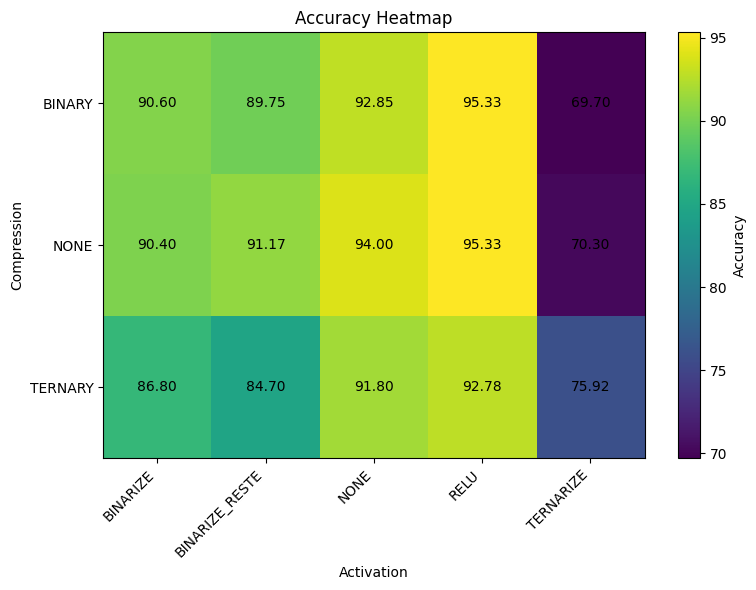

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique compression and activation names
compressions = sorted(set(d['compression'] for d in data))
activations = sorted(set(d['activation'] for d in data))

# Build accuracy matrix
heatmap = np.zeros((len(compressions), len(activations)))
for i, comp in enumerate(compressions):
    for j, act in enumerate(activations):
        accs = [d['accuracy'] for d in data if d['compression'] == comp and d['activation'] == act]
        heatmap[i, j] = np.mean(accs) if accs else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(activations)))
ax.set_yticks(np.arange(len(compressions)))
ax.set_xticklabels(activations, rotation=45, ha='right')
ax.set_yticklabels(compressions)

# Add numbers to each cell
for i in range(len(compressions)):
    for j in range(len(activations)):
        value = heatmap[i, j]
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="w" if value < np.nanmax(heatmap)/2 else "black")

# Add colorbar
plt.colorbar(im, ax=ax, label='Accuracy')

ax.set_xlabel('Activation')
ax.set_ylabel('Compression')
ax.set_title('Accuracy Heatmap')
plt.tight_layout()
plt.show()
